# Parameter estimation for reaction-diffusion models of biological invasions

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\Delta u(t,x) + u(t,x)(r(x) - \gamma u(t,x)), t\geq 0, x\in [0, 1]^2\\
\frac{\partial u(t,x)}{\partial n}\Big|_{x\in\partial\Omega}=\nabla u(t,x)\cdot n=0, t\geq0,\text{Neumann condition},\\
u(0,x)=u_0(x),x\in [0,1]^2
\end{cases}
$$

In all that follows,$\gamma$ et $D$ are considered known constant but $r(x)$ is a unknown varying constant.

This notebook reimplements with PINNs the article [_Parameter estimation for reaction-diffusion models of biological invasions_](https://link.springer.com/article/10.1007/s10144-013-0415-0) by Soubeyrand and Roques, 2014.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 3, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
#     [eqx.nn.Linear, 50, 50],
#     [jax.nn.tanh],
#     [eqx.nn.Linear, 50, 50],
#     [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    [jax.nn.softplus]
]
key, subkey = random.split(key)
init_param_fn, u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2)


In [6]:
init_nn_params = init_param_fn()

Create a DataGenerator object

In [7]:
n = 600
nb = 200
nt = 600
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 20
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
tmin = 0
tmax = 1
method = "uniform"

rar_parameters = {
    'start_iter':1000, # the gradient step at which RAR algo starts (enables a burn in period)
    'update_rate':1000, # nb of gradient steps between two RAR procedures
    'sample_size':500, # the size of the sample of collocation points from which the new collocation points will be taken
    'selected_sample_size':5, # the number of selected collocation points from the sample, to join the dataset.
}
n_start = 400 # the initial number of collocation points at beginning

Tmax = 2
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    tmin,
    tmax,
    method,
    rar_parameters=rar_parameters,
    n_start=n_start
)

## Set up the initial condition

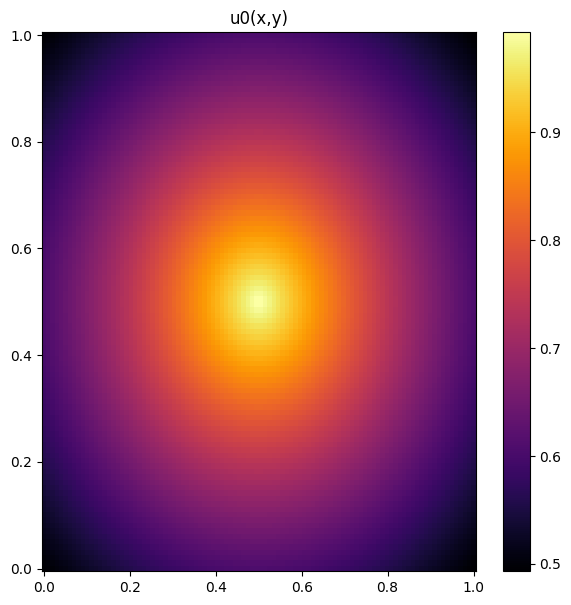

In [8]:
from jax.scipy.stats import norm
sigma_init = 1 * jnp.ones((2))
mu_init = jnp.array([0.5, 0.5])

def u0(x):
    return jnp.exp(-jnp.linalg.norm(x - mu_init))

nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

jinns.data.plot2d(
    fun=u0,
    xy_data=val_xy_data,
    title="u0(x,y)"
)

## True model parameters

We need to load the matrix containing the r values

(100, 100) [-4.  0.  2.]
2.0


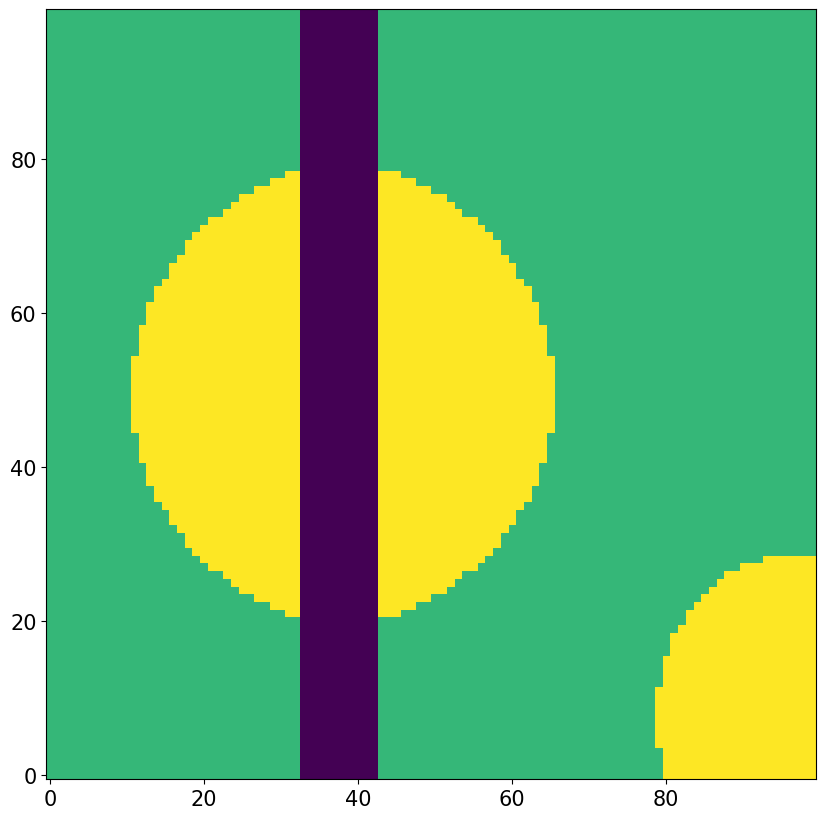

In [9]:
import matplotlib.image as img
r_map = (img.imread("simple_domain.png")[..., 0] * 255).astype(int).astype(float)
# Convert the pixel values to the real r values
r_map[r_map == 0] = -4.
r_map[r_map == 128] = 2.
r_map[r_map == 255] = 0.
print(r_map.shape, jnp.unique(r_map))

figsize = (20, 10)
fontsize = 15
linewidth = 7
plt.rcParams.update({'font.size': fontsize, 'figure.figsize':figsize})


plt.imshow(r_map.T, origin='lower')

plt.savefig("fisher_r.pdf", dpi=300, transparent = True, bbox_inches="tight")
print(r_map[50, 50])
# import numpy as np
# np.set_printoptions(threshold=np.inf)
# print(np.asarray(r_map))

In [10]:
D = 0.05
g = 1.

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [11]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "D":jnp.array([D]),
        "r":jnp.asarray(r_map),
        "g":jnp.array([g])
    }
}

## Loss construction

In [12]:
fisher_dynamic_loss = jinns.loss.FisherKPP2D(
    Tmax=Tmax,
    eq_params_heterogeneity={"D":None, "r":"space", "g":None}
)

In [13]:
loss_weights = {"dyn_loss":1, "temporal_loss": 10 * Tmax, "boundary_loss":1 * Tmax}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda dx: 0,
    omega_boundary_condition="neumann",
    temporal_boundary_fun=u0,
    norm_key=None,
    norm_borders=None,
    norm_samples=None
)

In [14]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 4.157865524291992
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '3.49', 'norm_loss': '0.00', 'observations': '0.00', 'temporal_loss': '0.03'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [15]:
params = init_params

In [16]:
# Optimizer
import optax
from jaxopt import OptaxSolver


tx = optax.adam(learning_rate=1e-3)
solver = OptaxSolver(opt=tx, fun=loss,
                     has_aux=True, # because the objective has aux output
                     maxiter=500000)


In [17]:
n_iter = int(200000)
pinn_solver = jinns.solver.PinnSolver(
    optax_solver=solver,
    loss=loss,
    n_iter=n_iter,
)

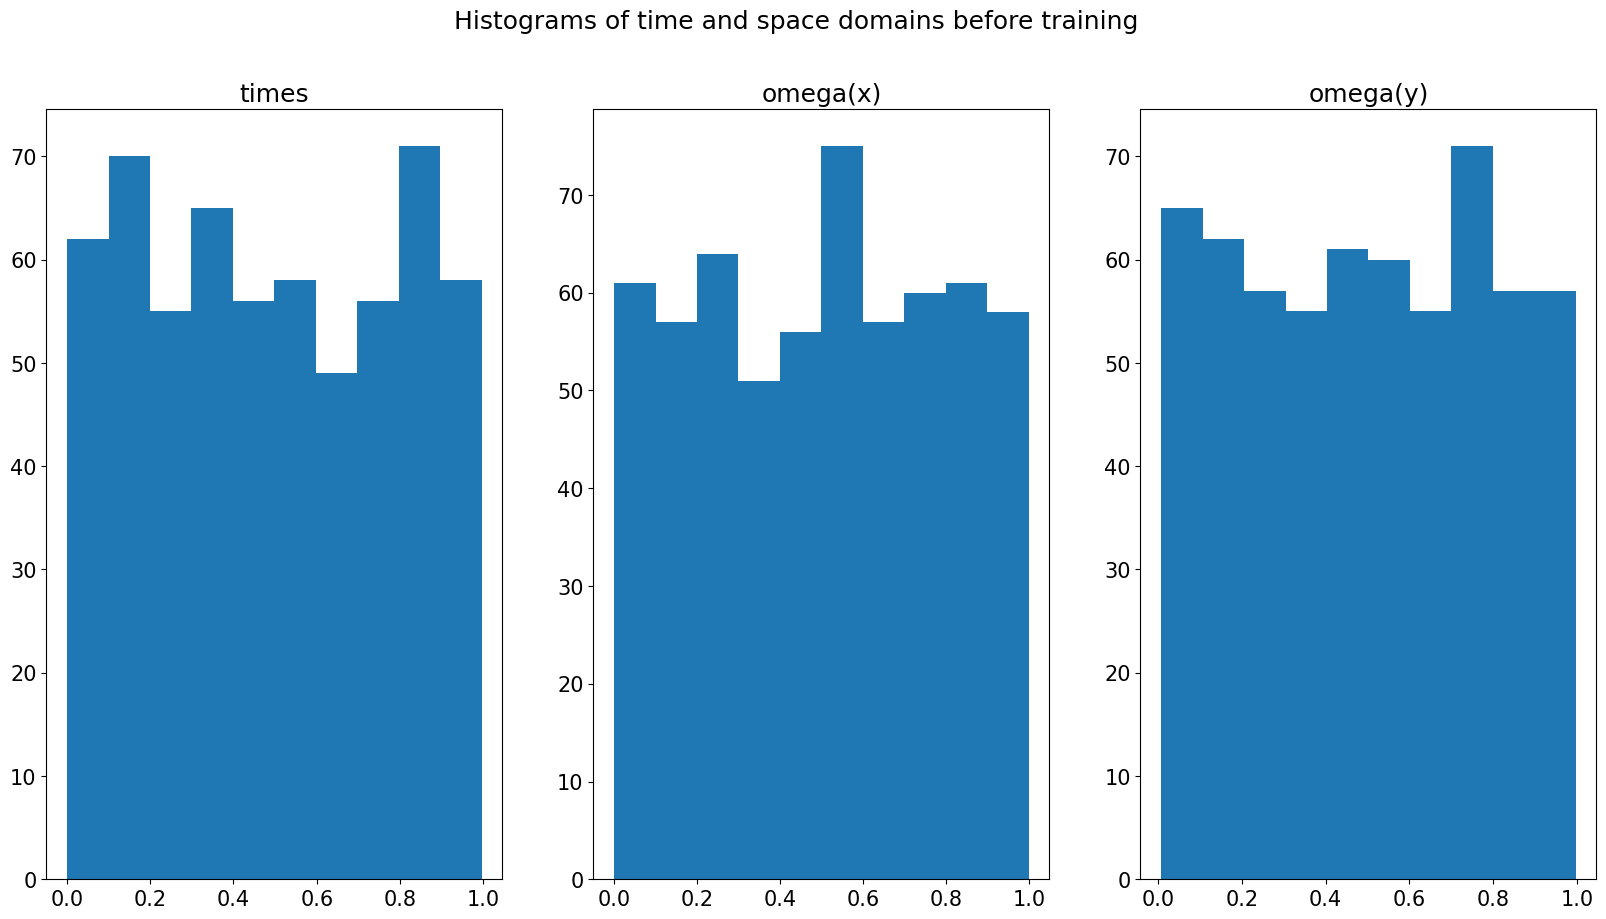

In [18]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.times)
ax[0].set_title('times')
ax[1].hist(train_data.omega[:, 0].flatten())
ax[1].set_title('omega(x)')
ax[2].hist(train_data.omega[:, 1].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains before training')
plt.savefig("hist_data_before.pdf")
plt.show()

In [19]:
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = pinn_solver.solve(
    init_params=params,
    data=train_data,
)

  0%|          | 0/200000 [00:00<?, ?it/s]

## Results

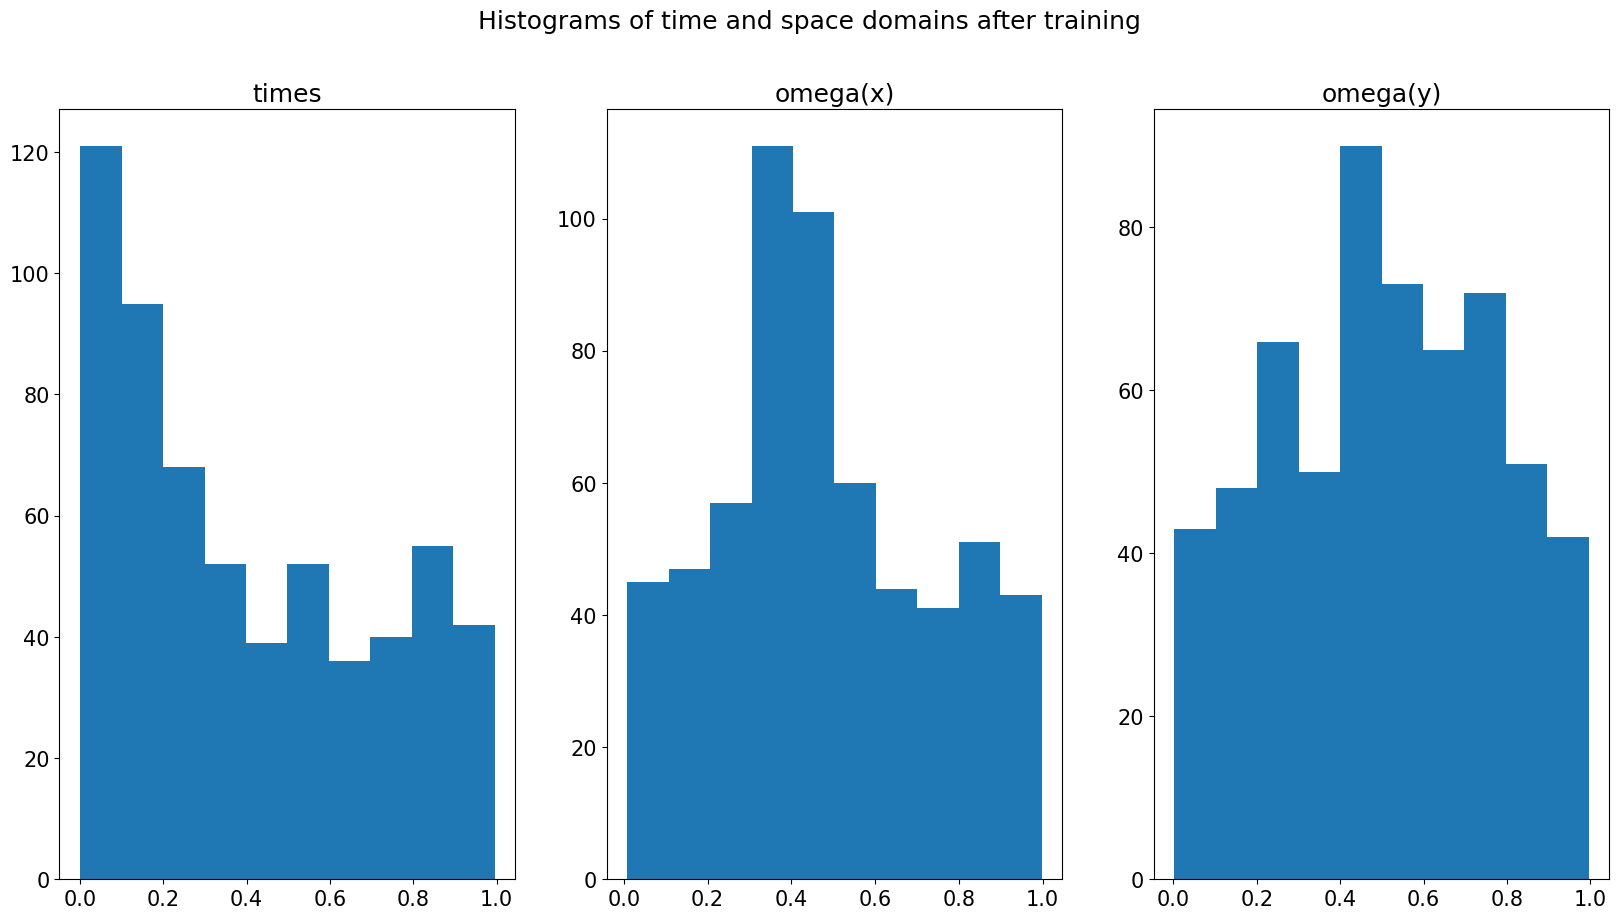

In [20]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(train_data.times)
ax[0].set_title('times')
ax[1].hist(train_data.omega[:, 0].flatten())
ax[1].set_title('omega(x)')
ax[2].hist(train_data.omega[:, 1].flatten())
ax[2].set_title('omega(y)')
fig.suptitle('Histograms of time and space domains after training')
plt.savefig("hist_data_after.pdf")
plt.show()

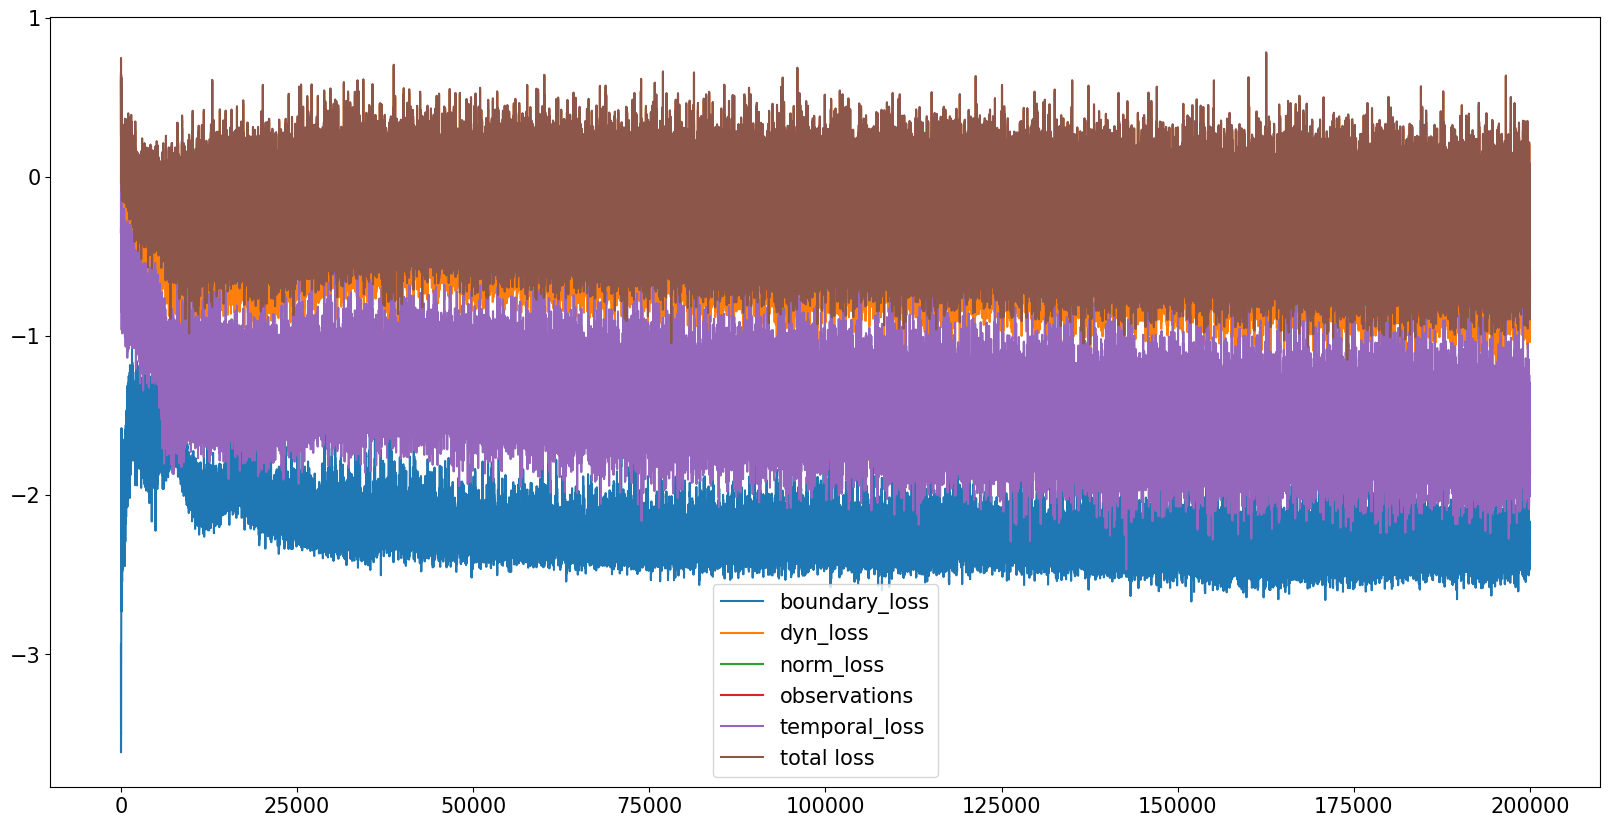

In [21]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the PDE solution learned by the PINN

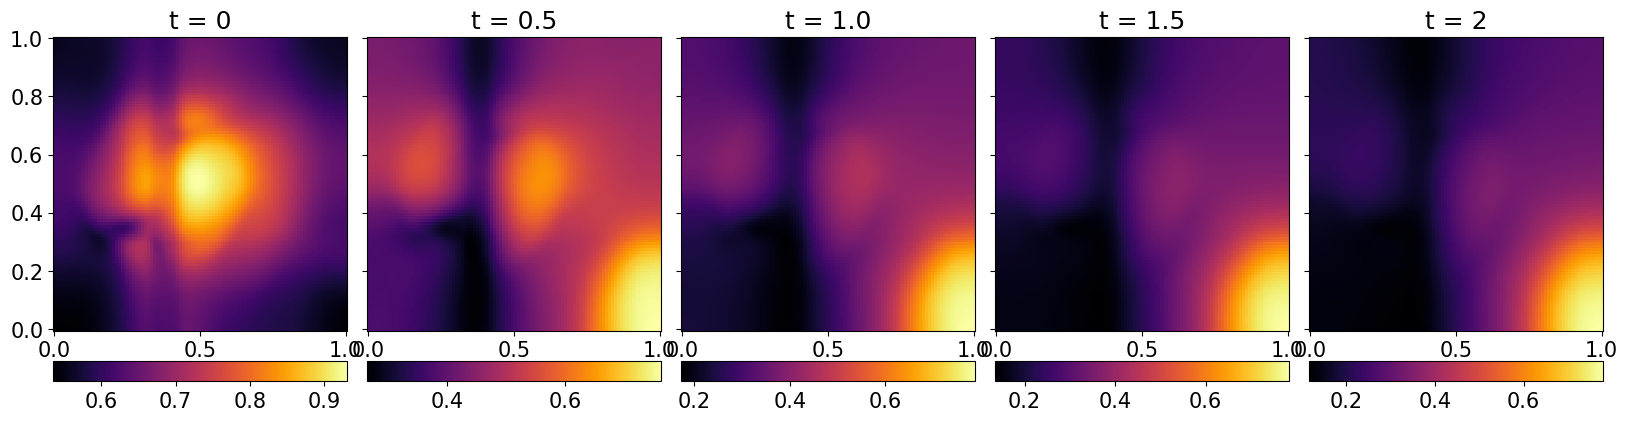

In [22]:
figsize = (20, 10)
fontsize = 15
linewidth = 7
plt.rcParams.update({'font.size': fontsize, 'figure.figsize':figsize})


times = [0, 0.25, 0.5, 0.75, 1] # times in the rescaled time susescale
u_est = partial(u, u_params=params["nn_params"])

jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=figsize, #(10, 10*len(times))
)

#plt.savefig("fisher_r_sol.pdf", dpi=300, transparent = True, bbox_inches="tight")
